<div class='alert-block alert-info'>
    <br>
    <h1 align="center"><b>  Programming in data science :</b> Final Project </h1>
    <h3 align="center">Earthquake dataset </h3>
    <h5 align="center">BONNELL Hugo - HAMADEH Rayan - BLANCHET Lucas - AFFES Nour - MAARBANI Yasmine - BRUN Pierre-Louis</a></h5>
    <br>
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from scipy.stats import zscore

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from plotly import express as px

# ARIMA : Library used in a green AI project to forecast, reusing it here
from statsmodels.tsa.arima.model import ARIMA

import dash
from dash import dcc, html
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
def import_csv(filePath):
    """
    Function for reading a CSV file

    Input: filePath <string> : The path to the CSV file.

    Returns : data <pd.DataFrame> : The data as a pandas' dataframe.

    """
    return pd.read_csv(filePath)

In [3]:
data = import_csv('earthquakes.csv')

## Exploratory Data Analysis 

In [4]:
# Number of rows and columns

def EDA(data):
    """
    This function aims to help explore the dataset
    
    Parameters: data <pandas.DataFrame> : dataset we're studying.

    Returns: None

    Prints: 
        1 - number of columns and rows
        2 - data type in each column
        3 - number of missing data per column
        4 - correlation between variables
    """
    row, col = data.shape
    print("The dataset has : ", row, " rows and ", col ," columns.")
    
    
    print("\n\n--------------------------------\n\n")
    print("Data Information : ")
    print(data.info())
    
    
    print("\n\n--------------------------------\n\n")
    print("Number of null per column:")
    print(data.isna().sum())
    
    
    print("\n\n--------------------------------\n\n")
    print("Correlation matrix:")

    # Compute the correlation matrix 
    data['Location_Name_Encoded'] = LabelEncoder().fit_transform(data['Location Name'])

    corr_matrix = data.drop(columns=['Location Name']).corr(method='pearson')

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
    plt.title("Correlation Matrix (Pearson Method)")
    plt.tight_layout()
    plt.show()

    data.drop(columns=['Location_Name_Encoded'], inplace=True)


The dataset has :  4424  rows and  38  columns.


--------------------------------


Data Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                4424 non-null   float64
 1   Mo                                  4330 non-null   float64
 2   Dy                                  4280 non-null   float64
 3   Hr                                  3665 non-null   float64
 4   Mn                                  3581 non-null   float64
 5   Sec                                 3437 non-null   float64
 6   Tsu                                 1390 non-null   float64
 7   Vol                                 36 non-null     float64
 8   Location Name                       4423 non-null   object 
 9   Latitude                            4424 non-null   float64
 10  Lon

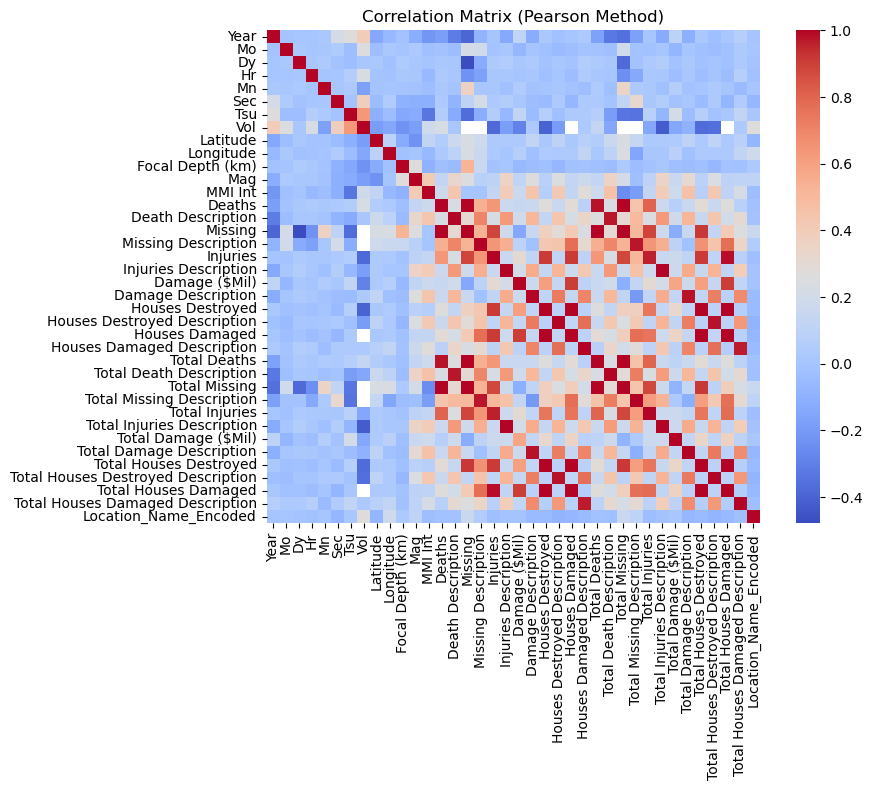

In [10]:
# Call Exploratory Data Analysis function on our dataset
EDA(data)

So from the EDA function we can see that:
- Our data set is of shape 4424x38.

- All of our columns are of time float except for the 'Location Name' column which contains an object (string) (which we encoded into an integer just for the correlation matrix so that we can study it as well).

- We have a significant issue regarding the null values in our columns which might pause problems later on.

- Correlation Matrix:
  - Recap about what correlation matrix helps with:
    A correlation matrix shows the pairwise relationships (correlations) between numerical variables in a dataset.

    Values range from -1 to 1:
        +1: Perfect positive correlation (both variables increase together).
        -1: Perfect negative correlation (one increases while the other decreases).
        0: No correlation (the variables are independent)
        
  - Key observations:
    - Variables like **Deaths**, **Total Deaths**, and **Death Description** are highly correlated, which makes perfect sense.
    - **Houses Destroyed** and **Total Houses Distroyed** are also highly correlated.

    - Negative correlation present between **Focal Depth** and **Damage** which helps us understand that if the focal depth increases, the damage decreases due to deeper quakes having less impact on the surface.

    - **Latitude** and **Temperature** are negatively correlated as well, which means higher latitudes (locations closer to the poles) are associated with lower temperatures.

## Analysis

In [109]:
def max_magnitude_by_year(data):
    """
    Finds the maximum earthquake magnitude for each year.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing 'Year' and 'Mag' columns.

    Returns:
    pd.DataFrame: A DataFrame showing the maximum magnitude per year.
    """
    result = data.groupby('Year')['Mag'].max().reset_index()
    result.columns = ['Year', 'Max_Magnitude']
    return result

In [110]:
def earthquakes_by_location(data):
    """
    Counts the total number of earthquakes for each location.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing 'Location Name'.

    Returns:
    pd.DataFrame: A summary DataFrame showing the total earthquakes per location.
    """
    result = data['Location Name'].value_counts().reset_index()
    result.columns = ['Location', 'Total_Earthquakes']
    return result

In [111]:
def monthly_distribution(data):
    """
    Extracts the month from 'Mo' column and counts earthquakes per month.

    Parameters:
    data (pd.DataFrame): The dataset containing 'Mo' column.

    Returns:
    pd.DataFrame: A summary of earthquakes by month.
    """
    result = data['Mo'].value_counts().sort_index().reset_index()
    result.columns = ['Month', 'Total_Earthquakes']
    return result

In [112]:
def average_depth_by_magnitude(data):
    """
    Groups earthquakes into magnitude ranges and calculates the average focal depth.

    Parameters:
    data (pd.DataFrame): The dataset containing 'Mag' and 'Focal Depth (km)' columns.

    Returns:
    pd.DataFrame: A DataFrame showing the average focal depth for each magnitude range.
    """
    bins = [0, 4, 6, 8, 10]  # Magnitude ranges
    labels = ['0-4', '4-6', '6-8', '8-10']
    
    # Create magnitude categories
    data['Magnitude_Range'] = pd.cut(data['Mag'], bins=bins, labels=labels)
    
    # Group by magnitude range and calculate the average focal depth
    result = data.groupby('Magnitude_Range')['Focal Depth (km)'].mean().reset_index()
    result.columns = ['Magnitude_Range', 'Avg_Focal_Depth']
    data.drop(columns=['Magnitude_Range'], inplace=True)
    return result

In [113]:
def discretize_magnitude(data):
    """
    Discretizes the earthquake magnitude into categories (Low, Medium, High, Extreme) 
    and plots them with specific colors.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing the 'Mag' column.

    Returns:
    pd.DataFrame: A DataFrame with an additional 'Magnitude_Category' column.
    """
    # Define magnitude bins and labels
    bins = [0, 4, 6, 7, 10]  # Magnitude ranges
    labels = ['Low', 'Medium', 'High', 'Extreme']

    # Discretize 'Mag' into categories
    data['Magnitude_Category'] = pd.cut(data['Mag'], bins=bins, labels=labels, include_lowest=True)

    # Display count of earthquakes in each category
    category_counts = data['Magnitude_Category'].value_counts().reindex(labels)  # Preserve order
    print("Earthquake Counts by Magnitude Category:")
    print(category_counts)

    # Define color mapping for each category
    color_map = {
        'Low': '#98FB98',       # Green
        'Medium': '#FFD700',    # Orange
        'High': '#FF6347',      # Light Red
        'Extreme': '#8B0000'    # Dark Red
    }

    # Plot the distribution of earthquake categories with mapped colors
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='bar', 
                         color=[color_map[cat] for cat in category_counts.index], 
                         edgecolor='black')
    plt.title('Earthquake Count by Magnitude Category')
    plt.xlabel('Magnitude Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal
    plt.show()

    return data

In [114]:

def normalize_magnitude(data):
    """
    Standardizes the earthquake magnitude using Z-score normalization.

    Parameters:
    data (pd.DataFrame): The earthquake dataset containing the 'Mag' column.

    Returns:
    pd.DataFrame: A DataFrame with an additional column for normalized magnitudes.
    """
    # Copy the data to avoid modifying the original DataFrame
    data_copy = data.copy()

    # Apply Z-score normalization to the 'Mag' column
    data_copy['Mag_Zscore'] = zscore(data_copy['Mag'], nan_policy='omit')

    # Identify extreme events where magnitude is greater than 2 standard deviations
    extreme_events = data_copy[data_copy['Mag_Zscore'] > 2]

    print("Top 5 Extreme Earthquake Events (Z-Score > 2):")
    print(extreme_events[['Location Name', 'Mag', 'Mag_Zscore']].head())

    return data_copy

In [115]:
def detect_earthquake_hotspots(data, eps=2, min_samples=10):
    """
    Detects earthquake hotspots using DBSCAN clustering.

    Parameters:
    data (pd.DataFrame): Earthquake dataset containing 'Latitude' and 'Longitude'.
    eps (float): The maximum distance between two samples for clustering.
    min_samples (int): The number of samples in a cluster.

    Returns:
    None: Displays a scatter plot of earthquake clusters.
    """
    # Step 1: Extract spatial data (latitude and longitude)
    spatial_data = data[['Latitude', 'Longitude']].dropna()

    # Step 2: Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    spatial_data['Cluster'] = dbscan.fit_predict(spatial_data)

    # Step 3: Visualize the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(spatial_data['Longitude'], spatial_data['Latitude'], 
                c=spatial_data['Cluster'], cmap='rainbow', s=10, alpha=0.7)
    plt.title("Earthquake Hotspots Detected Using DBSCAN")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Cluster")
    plt.show()

    # Display cluster information
    print("Number of clusters (excluding noise):", len(set(spatial_data['Cluster'])) - (1 if -1 in spatial_data['Cluster'] else 0))

(-197.99999999999997,
 198.00000000000014,
 -98.68225650000004,
 92.32738650000002)

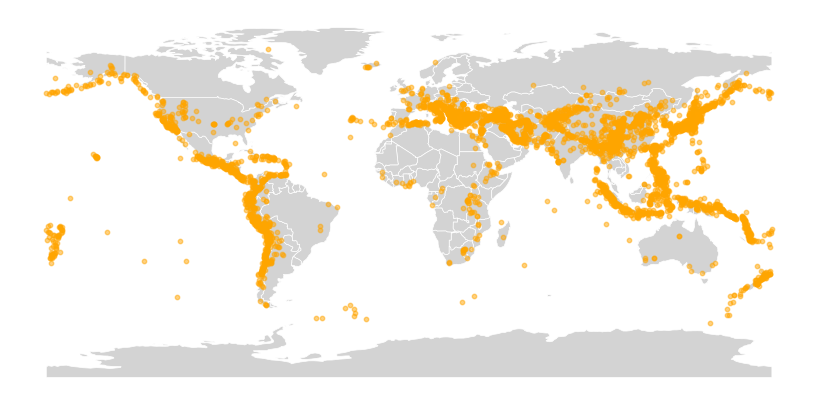

In [56]:
import geopandas
from shapely.geometry import Point

def make_point(row):
    return Point(row.Longitude, row.Latitude)

map_data = data[["Latitude", "Longitude", "Magnitude_Category"]].copy(deep=True)
points = map_data.apply(make_point, axis=1)

equake_points = geopandas.GeoDataFrame(map_data, geometry=points)

countries = geopandas.read_file('countries_shp/ne_110m_admin_0_countries.shp')

map = countries.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(15,5))
equake_points.plot(markersize=10, color='orange', alpha=0.5, ax=map)
map.axis('off')

In [ ]:
emap = px.scatter_mapbox(
    data[["Latitude","Longitude","Mag","Focal Depth (km)"]].dropna(),
    lat="Latitude",
    lon="Longitude",
    color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=0, color = "Mag", size = 'Focal Depth (km)')
emap.update_layout(mapbox_style="carto-positron")
emap.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
emap.show()

![Earthquakes map](EarthquakesMap.png)

In [119]:
def forecast_earthquakes(data, future_years=5):
    """
    Forecasts the number of earthquakes per year using ARIMA.

    Parameters:
    data (pd.DataFrame): Earthquake dataset containing 'Year'.
    future_years (int): Number of future years to forecast.

    Returns:
    pd.DataFrame: Forecasted number of earthquakes.
    """
    # Step 1: Count earthquakes per year
    earthquakes_per_year = data['Year'].dropna().astype(int).value_counts().sort_index()
    earthquakes_series = earthquakes_per_year.reindex(range(earthquakes_per_year.index.min(), 
                                                             earthquakes_per_year.index.max() + 1), 
                                                      fill_value=0)

    # Step 2: Build and fit ARIMA model
    model = ARIMA(earthquakes_series, order=(2, 1, 1))  # ARIMA parameters can be tuned
    model_fit = model.fit()

    # Step 3: Forecast for future years
    forecast = model_fit.forecast(steps=future_years)

    # Combine historical and forecasted data
    future_index = range(earthquakes_series.index.max() + 1, earthquakes_series.index.max() + 1 + future_years)
    forecast_df = pd.DataFrame({'Year': future_index, 'Forecasted_Earthquakes': forecast.values})

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(earthquakes_series[-200:], label="Historical Earthquakes")
    plt.plot(future_index, forecast, label="Forecasted Earthquakes", linestyle="--")
    plt.xlabel("Year")
    plt.ylabel("Number of Earthquakes")
    plt.title("Forecast of Earthquake Occurrences")
    plt.legend()
    plt.show()

    return forecast_df

## Main Program

In [132]:
def main_function():
    max_magnitude = max_magnitude_by_year(data)
    max_magnitude['Moving_Avg'] = max_magnitude['Max_Magnitude'].rolling(window=20).mean()

    fig1 = go.Figure(go.Scatter(x=max_magnitude['Year'], y=max_magnitude['Moving_Avg'], mode='lines', name='Max Magnitude'))
    fig1.update_layout(title="Average Max Magnitude per year", xaxis_title="Year", yaxis_title="Max Magnitude", xaxis=dict(range=[0, 2020]))
    

    monthly_earthquakes = monthly_distribution(data)
    fig1 = go.Figure(go.Scatter(x=max_magnitude['Year'], y=max_magnitude['Moving_Avg'], mode='lines', name='Max Magnitude'))
    fig1.update_layout(title="Average Max Magnitude per year", xaxis_title="Year", yaxis_title="Max Magnitude", xaxis=dict(range=[0, 2020]))


    dashboard_creator(fig1)

    return

def dashboard_creator(fig1):
    
    # Initialize the Dash app
    app = dash.Dash(__name__)

    # Dataset and Team Info
    dataset_name = "Earthquake Dataset"
    team_members = ["Alice", "Bob", "Charlie", "Diana"]

    # Example Data for Metrics (replace with actual data)
    years = list(range(2000, 2020))
    metric_2 = [i**0.5 for i in range(20)]  # Replace with your metric values
    metric_3 = [10 - (i * 0.3) for i in range(20)]  # Replace with your metric values
    metric_4 = [2 + (i * 0.1) for i in range(20)]  # Replace with your metric values

    fig2 = go.Figure(go.Bar(x=years, y=metric_2, name='Metric 2'))
    fig2.update_layout(title="Metric 2: Distribution", xaxis_title="Year", yaxis_title="Value")

    fig3 = go.Figure(go.Line(x=years, y=metric_3, name='Metric 3'))
    fig3.update_layout(title="Metric 3: Magnitude Analysis", xaxis_title="Year", yaxis_title="Value")

    fig4 = go.Figure(go.Scatter(x=years, y=metric_4, mode='lines', name='Metric 4'))
    fig4.update_layout(title="Metric 4: Depth Analysis", xaxis_title="Year", yaxis_title="Value")

    # Layout for Dash App
    app.layout = html.Div([
        # Header Section
        html.Div([
            html.H1("Earthquake Metrics Dashboard"),
            html.H3(f"Dataset: {dataset_name}"),
            html.H4(f"Team Members: {', '.join(team_members)}")
        ], style={'textAlign': 'center', 'marginBottom': '20px'}),
        
        # Metric Visualizations
        html.Div([
            html.Div([
                dcc.Graph(figure=fig1)
            ], className='six columns'),
            html.Div([
                dcc.Graph(figure=fig2)
            ], className='six columns'),
        ], className='row'),
        
        html.Div([
            html.Div([
                dcc.Graph(figure=fig3)
            ], className='six columns'),
            html.Div([
                dcc.Graph(figure=fig4)
            ], className='six columns'),
        ], className='row'),
    ], style={'margin': '20px'})


    app.run_server(debug=True)

    pass 

In [ ]:


earthquakes_location = earthquakes_by_location(data)
print(earthquakes_location[:10])


# Example usage
monthly_earthquakes = monthly_distribution(data)
print(monthly_earthquakes)

plt.figure(figsize=(8, 6))
monthly_earthquakes["Total_Earthquakes"].plot(kind='bar', color='#1e8cbf', edgecolor='black')
plt.title('Total Earthquakes per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.show()


discretized_data = discretize_magnitude(data)



normalized_data = normalize_magnitude(data)

# Display histogram to show distribution of normalized magnitudes

plt.figure(figsize=(10, 6))
plt.hist(normalized_data['Mag_Zscore'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Earthquake Magnitude (Z-Score Normalized)')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()


detect_earthquake_hotspots(data, eps=2, min_samples=10)




# Example usage
forecasted_earthquakes = forecast_earthquakes(data, future_years=5)
print("Forecasted earthquakes for the next 5 years:")
print(forecasted_earthquakes)

In [133]:
# Run the app
if __name__ == "__main__":
    main_function()

c:\Users\hbonn\anaconda3\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


